<a href="https://www.kaggle.com/code/emilymsung/step-by-step-nlp-with-disaster-tweets?scriptVersionId=112152107" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Step-by-step NLP with Disaster Tweets

👋🏻 Welcome to my notebook!<br>
<br>
We're going to use the Twitter dataset from Kaggle's Getting Started Competition, [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started). We'll go through a step-by-step process to make predictions whether a given Tweet is about a real disaster or not. Please upvote if you find it helpful.

Let's get started!


***

## Table of Contents

#### 1. [Exploratory Data Analysis](#explore)
#### 2. [Text Preprocessing - Part I](#preprocess1)
#### 3. [Feature Engineering](#engineer)
#### 4. [Text Preprocessing - Part II](#preprocess2)
#### 5. [Model Building](#build)
#### 6. [Model Evaluation](#evaluate)
#### 7. [Final Model Selection](#select)

***

## <a id="explore">✔️ Exploratory Data Analysis</a>

* Data source: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data)
* License: [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)

* Credibility: Medium-high 
    * **Reliable & Original: Yes** - The data was created by the company figure-eight and originally shared on their website (source: 'Acknowledgements' section on this [Kaggle page](https://www.kaggle.com/competitions/nlp-getting-started/overview)). It has been used for one of Kaggle's 'Getting Started' competitions. 
    * **Comprehensive: Yes** - The dataset includes 10,876 Tweets that were hand classified. Although there are lots of missing data in the 'keyword' and 'location' columns, the 'text' column we will focus on in this notebook has no missing or duplicated values. 
    * **Current: No** - The data was collected in 2015.
    * **Cited: Yes** - The data has been cited and used for many data science projects in many platforms including Kaggle.  

* Files in the dataset:

|File Name||# of Rows||# of Columns|
|:-:||:-:||:-:|
|sample_submission||3263||2|
|train||7613||5|
|test||3263||4|

Let's import the libraries and files and start exploring our data. First, we will check the data format, shape, missing data and for duplicates.

In [1]:
# import the libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, string
import nltk
import spacy

In [2]:
# set how many characters to show on the dataframe
pd.set_option('display.max_colwidth', 150)

# import the files as pandas dataframe
sample_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
# check the dataframes one by one, starting from sample_df
sample_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [4]:
# check the shape
sample_df.shape

(3263, 2)

In [5]:
# check the missing data
sample_df.isnull().sum()

id        0
target    0
dtype: int64

In [6]:
# check train_df
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [7]:
# check the shape
train_df.shape

(7613, 5)

In [8]:
# check the missing data
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
# check the duplicated data
train_df.duplicated().sum()

0

In [10]:
# check test_df
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# check the shape
test_df.shape

(3263, 4)

In [12]:
# check the missing data
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [13]:
# check the duplicated data
test_df.duplicated().sum()

0

|File Name||# of missing values (column)||# duplicated values (column)|
|:-:||:-:||:-:|
|sample_submission||0||0|
|train||61 (keyword), 2533 (location)||0|
|test||26 (keyword), 1105 (location)||0|

- Missing values were found only in 'keyword' and 'location' columns of the train and test datasets. No duplicated values were found.

<div class="alert alert-block alert-info">
    <b>Tips:</b> I included the individual steps above for reference. Another thing you can do is use for example something like <a href='https://github.com/ydataai/pandas-profiling'>Pandas Profiling</a>, a Python package for quick EDA! <br>df.profile_report() provides a detailed report including an overview, variables, correlations, missing values and sample of your dataset.<br> 

### Is the Dataset Balanced or Imbalanced?

Why is it important to check if your data is balanced or imbalanced? Why can imbalanced data be problematic? How should we deal with it? This short explanation on [the Google Developer page](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) is a great place to start. 

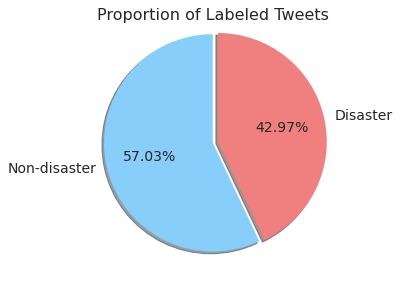

In [14]:
# set the figure size
plt.figure(figsize=(9, 5))

# set the style
plt.style.use('seaborn-darkgrid')

# set the colors
colors = ['lightskyblue', 'lightcoral']

# generate a pie plot
plt.pie(train_df['target'].value_counts(), explode=(0, 0.05), labels=["Non-disaster", "Disaster"], 
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90, colors=colors)

# add a title
plt.title('Proportion of Labeled Tweets', size=16, y=0.93)

# show the plot
plt.show()

- **Our dataset is well balanced**, and accuracy would not be a poor metric for evaluating our classification models.

### Word Clouds Using Unprocessed Text

Let's visualize the unprocessed text as a word cloud. The size of text shows the frequency that the word appears in the dataset.

In [15]:
# set the random state
random_state = 4041

# import the wordcloud library
from wordcloud import WordCloud

# concat all the text for each labels
non_disaster_text = [''.join(t) for t in train_df[train_df['target']==0]['text']]
non_disaster_strings = ''.join(map(str, non_disaster_text))
disaster_text = [''.join(t) for t in train_df[train_df['target']==1]['text']]
disaster_strings = ''.join(map(str, disaster_text))

# generate word clouds
non_disaster_cloud = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(non_disaster_strings)
disaster_cloud = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(disaster_strings)

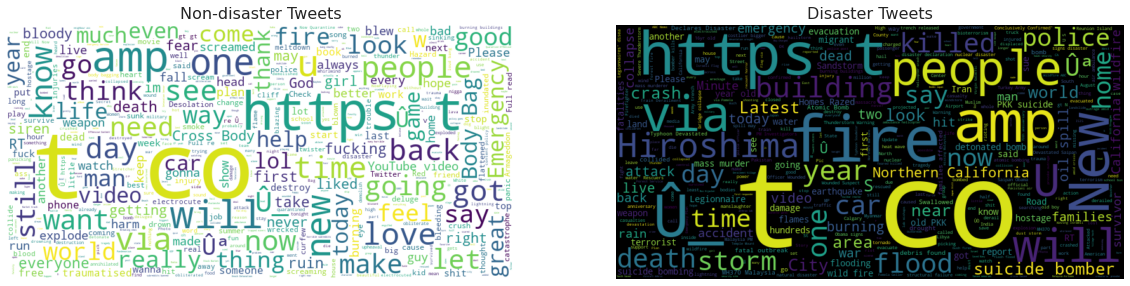

In [16]:
# create subplots for the generated clouds
fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[1].imshow(disaster_cloud, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes]

# add titles
axes[0].set_title('Non-disaster Tweets', fontsize=16)
axes[1].set_title('Disaster Tweets', fontsize=16)

# show the figure
plt.show()

We can recognize some disaster-related words (e.g., 'fire', 'flood', and 'storm'), but the difference between disaster and non-disaster Tweets is not easy to tell. Words like "t"and "co" (reflecting shortened links on Twitter) dominate the clouds, but don't provide much helpful meaning. **Let's compare these with word clouds of preprocessed data later on.** 

***

## <a id="preprocess1">🧾 Text Preprocessing - Part I</a>

Let's start preprocessing our text by removing the parts below: 
- URLs
- HTML tags
- character references
- non-printable characters
- numeric values

We'll come back to the preprocessing step after creating some new features.

### Remove URLs

In [17]:
# define a function that removes URLs from the text
def remove_url(text):
    text = re.sub('\\b((?:https?|ftp|file)://[-a-zA-Z0-9+&@#/%?=~_|!:, .;]*[-a-zA-Z0-9+&@#/%=~_|])', '', text)
    return text

# remove URLs from the text and show the modified text in a new column
train_df['text_cleaned'] = train_df['text'].apply(remove_url)
test_df['text_cleaned'] = test_df['text'].apply(remove_url)

### Remove HTML tags

In [18]:
# define a function that removes HTML tags
def remove_HTML(text):
    text = re.sub(r'<.*?>', '', text)
    return text

# remove HTML tags
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_HTML)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_HTML)

### Remove Character References

In [19]:
# define a function to remove character references (e.g., &lt;, &amp;, &nbsp;)
def remove_references(text):
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    return text

# remove character references
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_references)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_references)

### Remove Non-printable Characters

In [20]:
# check which characters are printable (ASCII)
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [21]:
# define a function that removes non-printable characters
def remove_non_printable(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# remove non-printable characters
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_non_printable)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_non_printable)

### Remove Numeric Values
Remove numeric values, including mixtures of alphabetical characters and numeric values such as 'M194', '5km'.

In [22]:
# define a function that removes numeric values and mixtures
def remove_num(text):
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

# remove numeric values and mixtures
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_num)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_num)

In [23]:
# check the results
train_df.tail()

,id,keyword,location,text,target,text_cleaned
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding a bridge collapse into nearby homes
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,. [: UTC]? S of Volcano Hawaii.
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1,The Latest: More Homes Razed by Northern California Wildfire - ABC News


In [24]:
# check the results
test_df.tail()

,id,keyword,location,text,text_cleaned
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,Storm in RI worse than last hurricane. My hardest hit. My yard looks like it was bombed. Around still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,Green Line derailment in Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,MEG issues Hazardous Weather Outlook (HWO)
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm


In Text Preprocessing - Part II, we'll lemmatize and lowercase our text, and remove repeated characters in elongated words, as well as mentions, stopwords, and punctuation.

***

## <a id="engineer">📐 Feature Engineering</a>

Below are 10 features we're going to create:

- Number of **sentences**
- Number of **words**
- Number of **characters**
- Number of **hashtags**
- Number of **mentions**
- Number of **all caps words**
- Average **length of words**
- Number of **proper nouns (PROPN)**
- Number of **non-proper nouns (NOUN)**
- Percentage of characters that are **punctuation**


### Number of Sentences

In [25]:
# create a new feature for the number of sentences in each Tweet
train_df['sent_count'] = train_df['text'].apply(nltk.tokenize.sent_tokenize).apply(len)
test_df['sent_count'] = test_df['text'].apply(nltk.tokenize.sent_tokenize).apply(len)

### Number of Words

In [26]:
# create a new feature for the number of words
train_df['word_count'] = train_df['text'].apply(nltk.tokenize.word_tokenize).apply(len)
test_df['word_count'] = test_df['text'].apply(nltk.tokenize.word_tokenize).apply(len)

### Number of Characters

In [27]:
# create a new feature for the number of characters excluding white spaces
train_df['char_count'] = train_df['text'].apply(lambda x: len(x) - x.count(" "))
test_df['char_count'] = test_df['text'].apply(lambda x: len(x) - x.count(" "))

### Number of Hashtags

In [28]:
# define a function that returns the number of hashtags in a string
def hash_count(string):
    words = string.split()
    hashtags = [w for w in words if w.startswith('#')]
    return len(hashtags)

# create a new feature for the number of hashtags
train_df['hash_count'] = train_df['text'].apply(hash_count)
test_df['hash_count'] = test_df['text'].apply(hash_count)

### Number of Mentions

In [29]:
# define a function that returns the number of mentions in a string
def ment_count(string):
    words = string.split()
    mentions = [w for w in words if w.startswith('@')]
    return len(mentions)

# create a new feature for the number of mentions
train_df['ment_count'] = train_df['text'].apply(ment_count)
test_df['ment_count'] = test_df['text'].apply(ment_count)

### Number of All Caps Words

In [30]:
# define a function that returns the number of words in all CAPS
def all_caps_count(string):
    words = string.split()
    pattern = re.compile(r'\b[A-Z]+[A-Z]+\b')
    capsWords = [w for w in words if w in re.findall(pattern, string)]
    return len(capsWords)

# create a new feature for the number of words in all CAPS
train_df['all_caps_count'] = train_df['text'].apply(all_caps_count)
test_df['all_caps_count'] = test_df['text'].apply(all_caps_count)

### Average Length of words

In [31]:
# define a function that returns the average length of words
def avg_word_len(string):
    words = string.split()
    total_len = sum([len(words[i]) for i in range(len(words))])
    avg_len = round(total_len / len(words), 2)
    return avg_len

# create a new feature for the average length of words
train_df['avg_word_len'] = train_df['text'].apply(avg_word_len)
test_df['avg_word_len'] = test_df['text'].apply(avg_word_len)

### Number of Proper Nouns (PROPN)
It is known that fake news tends to use more proper nouns than real news ([this article](https://arxiv.org/pdf/1703.09398.pdf) is a great resource to learn about how NLP helps us detect the fake news). Would the number of proper nouns in Tweets tell us anything about whether a given Tweet is an actual disaster-related Tweet or not? Let's try it out.

In [32]:
# define a function using nltk that returns the number of proper nouns in the text
def propn_count_nltk(text):    
    tokens = nltk.word_tokenize(text)
    tagged = [token for token in nltk.pos_tag(tokens)]
    propn_count = len([token for (token, tag) in tagged if tag == 'NNP' or tag == 'NNPS'])
    return propn_count

# create a new feature for the number of proper nouns
train_df['propn_count_nltk'] = train_df['text'].apply(propn_count_nltk)
test_df['propn_count_nltk'] = test_df['text'].apply(propn_count_nltk)

In [33]:
# check the results
train_df[['id', 'text', 'text_cleaned', 'propn_count_nltk']].head()

,id,text,text_cleaned,propn_count_nltk
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,4
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,5
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
3,6,"13,000 people receive #wildfires evacuation orders in California",", people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,2


Looking at the results, we can easily tell **nltk** did not do a good job detecting proper nouns here. The first text, "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all" doesn't seem to have 4 proper nouns. Let's check which tokens were tagged as proper nouns.

In [34]:
# test how nltk worked with the first text
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token, tag) for (token, tag) in nltk.pos_tag(nltk.word_tokenize(string)) if tag == 'NNP'])

[('Reason', 'NNP'), ('May', 'NNP'), ('ALLAH', 'NNP'), ('Forgive', 'NNP')]


Non-proper nouns that begin with an uppercase letter were tagged as proper-nouns! Would have it been correctly tagged if the string was converted to lowercase first?

In [35]:
# test how nltk works with the first text after lowercasing it
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token, tag) for (token, tag) in nltk.pos_tag(nltk.word_tokenize(string.lower())) if tag == 'NNP'])

[]


No, now with the lowercased text, nltk does not tag "allah" as a proper noun. Let's try with **spaCy** this time.

In [36]:
# load the model
nlp = spacy.load('en_core_web_sm')

# check the same string with spaCy
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token.text, token.pos_) for token in nlp(string) if token.pos_=='PROPN'])

[('ALLAH', 'PROPN')]


SpaCy correctly picked up the proper noun from the string. Let's create the feature of the number of proper nouns in the text with spaCy and remove the one we previously created with nltk.

In [37]:
# define a function that returns number of proper nouns with spaCy
def propn_count(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('PROPN')

# create a new feature for numbers of proper nouns
train_df['propn_count'] = train_df['text'].apply(propn_count)
test_df['propn_count'] = test_df['text'].apply(propn_count)

In [38]:
# remove 'propn_count_nltk' columns
train_df = train_df.drop(['propn_count_nltk'], axis=1)
test_df = test_df.drop(['propn_count_nltk'], axis=1)

In [39]:
# check the results
train_df[['id', 'text', 'text_cleaned', 'propn_count']].head()

,id,text,text_cleaned,propn_count
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,4
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
3,6,"13,000 people receive #wildfires evacuation orders in California",", people receive #wildfires evacuation orders in California",1
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,2


SpaCy is not perfect, either - "La Ronge" in the second text (id:4) is one proper noun not two, but it is clear that spaCy still performs better than nltk on this specific task. Let's use spaCy for the next feature as well. 

### Number of Non-proper Nouns (NOUN)

In [40]:
# define a function that returns number of non-proper nouns
def noun_count(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('NOUN')

# create a new feature for numbers of non-proper nouns
train_df['noun_count'] = train_df['text'].apply(noun_count)
test_df['noun_count'] = test_df['text'].apply(noun_count)

### Percentage of Characters that are Punctuation

In [41]:
import string

# define a function that returns the percentage of punctuation
def punc_per(text):
    total_count = len(text) - text.count(" ")
    punc_count = sum([1 for c in text if c in string.punctuation])
    if punc_count != 0 and total_count != 0:
        return round(punc_count / total_count * 100, 2)
    else:
        return 0

# create a new feature for the percentage of punctuation in text
train_df['punc_per'] = train_df['text'].apply(punc_per)
test_df['punc_per'] = test_df['text'].apply(punc_per)

In [42]:
# check the results
train_df.tail()

,id,keyword,location,text,target,text_cleaned,sent_count,word_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count,noun_count,punc_per
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding a bridge collapse into nearby homes,1,13,73,0,0,0,6.64,0,4,6.85
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,2,24,106,0,2,0,5.30,1,5,4.72
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,. [: UTC]? S of Volcano Hawaii.,2,15,58,0,0,0,7.25,6,1,18.97
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,2,21,119,0,0,0,6.26,2,7,4.20
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1,The Latest: More Homes Razed by Northern California Wildfire - ABC News,1,16,82,0,0,1,6.31,6,1,8.54


In [43]:
# check the results
test_df.tail()

,id,keyword,location,text,text_cleaned,sent_count,word_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count,noun_count,punc_per
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS XrWn,1,8,48,0,0,6,6.00,3,4,0.00
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,Storm in RI worse than last hurricane. My hardest hit. My yard looks like it was bombed. Around still without power,4,30,117,0,0,1,5.09,1,6,4.27
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,Green Line derailment in Chicago,1,8,50,0,0,0,8.33,3,2,10.00
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,MEG issues Hazardous Weather Outlook (HWO),1,11,59,0,0,1,8.43,4,3,11.86
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm,2,11,61,2,0,0,7.62,4,0,4.92


***

## <a id="preprocess2">🧾 Text Preprocessing - Part II</a>
Let's resume our text preprocessing and **lemmatize** the text and make it **lowercase**. We'll also **remove repeated characters in elongated words, as well as mentions, stopwords, and punctuation**. We'll keep hashtags as they may provide valuable insights in this particular project. 

### Lemmatization

In [44]:
# lemmatize the text
train_df['text_cleaned'] = train_df['text_cleaned'].apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))
test_df['text_cleaned'] = test_df['text_cleaned'].apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))

### Convert the Text to Lowercase

In [45]:
# lowercase the text
train_df['text_cleaned'] = [t.lower() for t in train_df['text_cleaned']]
test_df['text_cleaned'] = [t.lower() for t in test_df['text_cleaned']]

### Remove Repeated Charcters in Elongated Words

In [46]:
# define a function that removes repeated characters in elongated words
def remove_repeated(text):
    elongated = re.compile(r'(\S*?)([a-z])\2{2,}')
    text = elongated.sub(r'\1\2', text)
    return text

# remove repeated characters in elongated words
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_repeated)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_repeated)

### Remove Mentions

In [47]:
# define a function that removes mentions
def remove_mention(text):
    text = re.sub(r'@\w+', '', text)
    return text

# remove mentions
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_mention)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_mention)

### Remove Stopwords

In [48]:
# define a function that removes stopwords
def remove_stopwords(text):
    stopwords = nlp.Defaults.stop_words
    text_nostop = ' '.join([token for token in text.split() if token not in stopwords])
    return text_nostop

# remove stopwords
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_stopwords)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_stopwords)

### Remove Punctuation

In [49]:
# define a function to remove punctuation
def remove_punct(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# remove punctuation
train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_punct)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_punct)

In [50]:
# check the results
train_df[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resident ask shelter place notify officer evacuation shelter place order expect
3,6,"13,000 people receive #wildfires evacuation orders in California",people receive wildfire evacuation order california
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got send photo ruby alaska smoke wildfire pour school


In [51]:
# check the results
test_df[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,0,Just happened a terrible car crash,happen terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese flee street save
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


### Raw vs. Preprocessed Text with Word Clouds

Let's generate word clouds of preprocessed text.

In [52]:
# concat all the preprocessed text for both labels
non_disaster_processed = [''.join(t) for t in train_df[train_df['target']==0]['text_cleaned']]
non_disaster_processed_s = ''.join(map(str, non_disaster_processed))
disaster_processed = [''.join(t) for t in train_df[train_df['target']==1]['text_cleaned']]
disaster_processed_s = ''.join(map(str, disaster_processed))

# generate word clouds of the preprocessed text
non_disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(non_disaster_processed_s)
disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(disaster_processed_s)

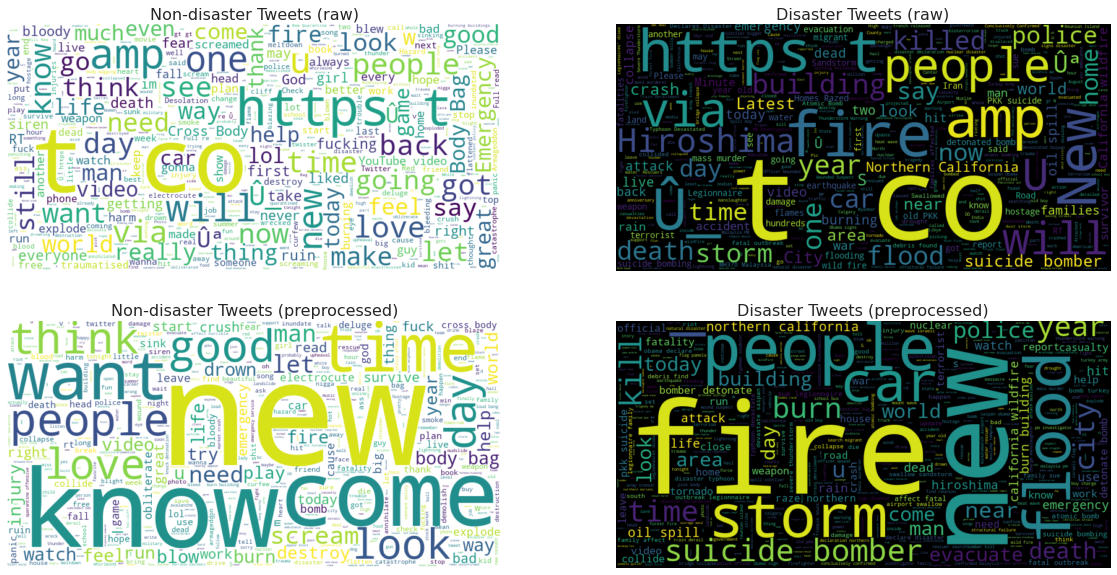

In [53]:
# create subplots for the generated clouds
fig, axes = plt.subplots(2, 2, figsize = (20,10))
axes[0,0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[0,1].imshow(disaster_cloud, interpolation='bilinear')
axes[1,0].imshow(non_disaster_processed_wc, interpolation='bilinear')
axes[1,1].imshow(disaster_processed_wc, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes.ravel()]

# add titles
axes[0,0].set_title('Non-disaster Tweets (raw)', fontsize=16)
axes[0,1].set_title('Disaster Tweets (raw)', fontsize=16)
axes[1,0].set_title('Non-disaster Tweets (preprocessed)', fontsize=16)
axes[1,1].set_title('Disaster Tweets (preprocessed)', fontsize=16)

# show the figure
plt.show()

Now it's easier to see the frequently used words that actually are meaningful. It also seems like **more disaster-related words are showing on the word cloud of real disaster Tweets**.

### 📊 Visualizing Differences
Let's visualize some of the features we've created and see if there are easy-to-tell differences between disaster and non-disaster Tweets in our training dataset.

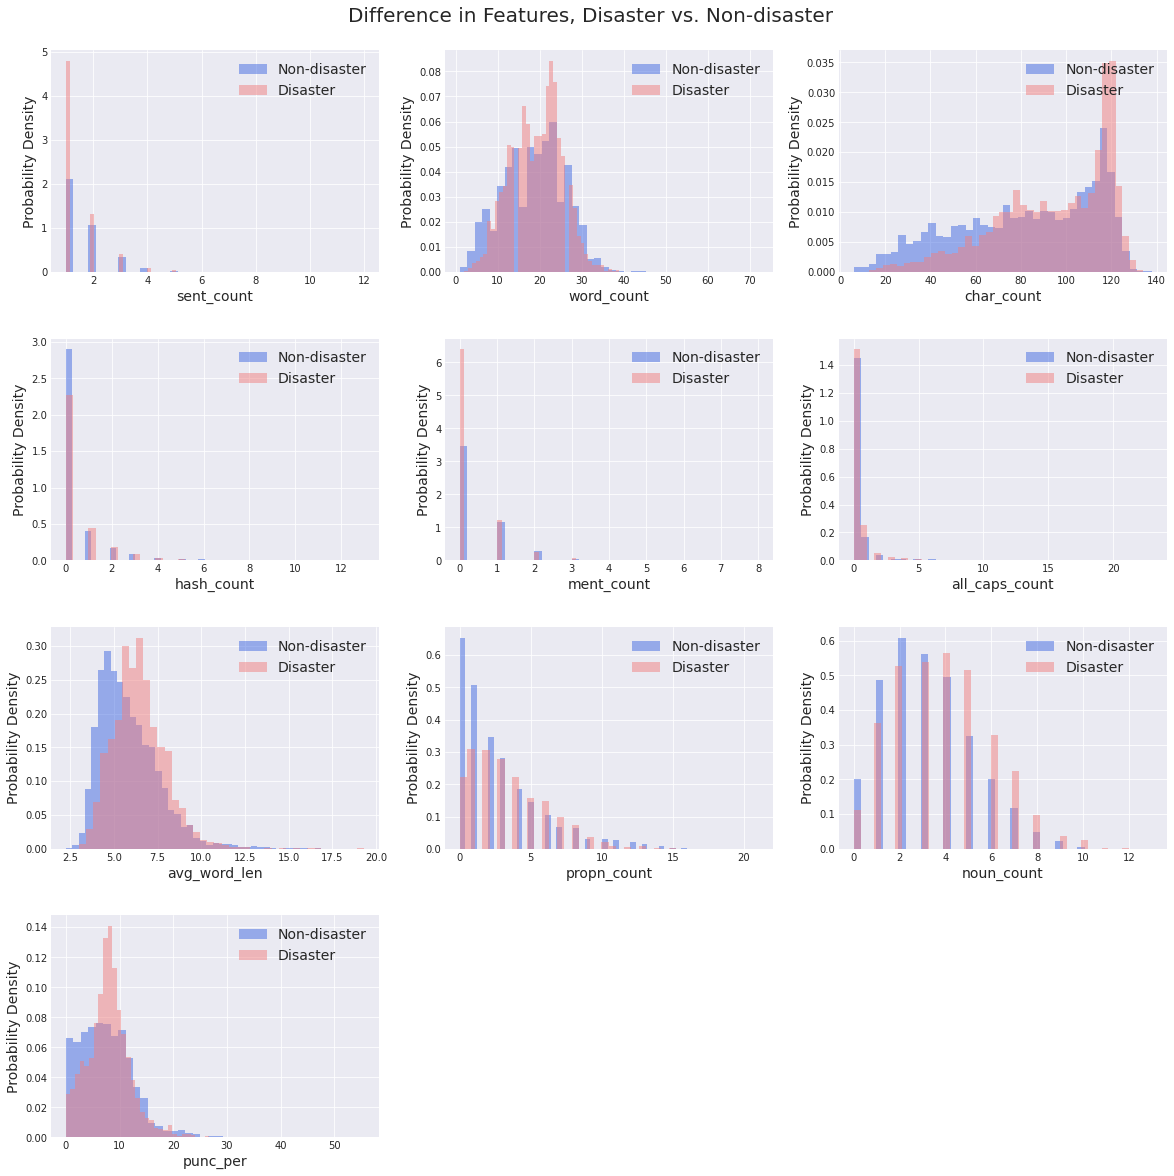

In [54]:
# store the features and their names in variables
features = ['sent_count', 'word_count', 'char_count', 'hash_count', 'ment_count', 'all_caps_count', 
            'avg_word_len', 'propn_count', 'noun_count', 'punc_per']

# create the figure
fig = plt.figure(figsize=(20, 20))

# adjust the height of the padding between subplots to avoid overlapping
plt.subplots_adjust(hspace=0.3)

# add a centered suptitle to the figure
plt.suptitle("Difference in Features, Disaster vs. Non-disaster", fontsize=20, y=0.91)

# generate the histograms in a for loop
for i, feature in enumerate(features):
    
    # add a new subplot iteratively
    ax = plt.subplot(4, 3, i+1)
    ax = train_df[train_df['target']==0][feature].hist(alpha=0.5, label='Non-disaster', bins=40, color='royalblue', density=True)
    ax = train_df[train_df['target']==1][feature].hist(alpha=0.5, label='Disaster', bins=40, color='lightcoral', density=True)
    
    # set x_label, y_label, and legend
    ax.set_xlabel(features[i], fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    

# shot the figure
plt.show()

- We'll use the four features, **word_count, char_count, avg_word_len, and punc_per**, for our models as they show bigger differences in distributions than other features we've created.
- Note: The y-axis in the plots above is probability density, not # of Tweets due to the different size of disaster/non-disaster Tweets. 

Now let's move on and start building our models!

***

## <a id="build">🔨 Model Building</a>

### Vectorizing Text & Selecting Input/Output

In [55]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate the vectorizer
tfidf = TfidfVectorizer()

# fit and transform
X_tfidf = tfidf.fit_transform(train_df['text_cleaned'])

In [56]:
# create a dataframe from the sparse matrix
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

# check the dataframe
X_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11704,11705,11706,11707,11708,11709,11710,11711,11712,11713
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# get the feature names from our stored vectorizer and assign them to X_tfidf_df
# to avoid getting 'FutureWarning: Feature names only support names that are strings.'
X_tfidf_df.columns = tfidf.get_feature_names_out()

# check the column names
X_tfidf_df.columns

Index(['__', 'aa', 'aan', 'aand', 'aar', 'aashiqui', 'ab', 'aba', 'abandon',
       'abbandone',
       ...
       'zombie', 'zone', 'zonesthank', 'zoom', 'zotar', 'zouma', 'zrnf', 'zss',
       'zumiez', 'zurich'],
      dtype='object', length=11714)

In [58]:
# create the new dataframe, X_features
X_features = pd.concat([train_df[['word_count', 'char_count', 'avg_word_len', 'punc_per']],
                        X_tfidf_df], axis=1)

# check the shape
X_features.shape

(7613, 11718)

In [59]:
# check the dataframe
X_features.head()

,word_count,char_count,avg_word_len,punc_per,__,aa,aan,aand,aar,aashiqui,...,zombie,zone,zonesthank,zoom,zotar,zouma,zrnf,zss,zumiez,zurich
0,14,57,4.38,1.75,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,32,4.57,3.12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24,112,5.09,2.68,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,57,7.12,3.51,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,72,4.50,2.78,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting Into Train and Validation Data
We're going to split our preprocessed training dataset into training subset and validation subset. The former will be used to train our models, while as the latter is heldout for validation.

In [60]:
# import the library
from sklearn.model_selection import train_test_split

# select the input/output
X = X_features
y = train_df['target']

# split the data
# the names, X_val and y_val, are used instead of X_test and y_test to avoid confusion with our actual test data
# which we will be using to make the predictions with the selected model at the end of this notebook
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

### Building Models

In [61]:
# import the libraries
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
# create a dictionary containing the names and code of algorithms
clfs = {'mnb': MultinomialNB(), 
        'svc': SVC(random_state=random_state), 
        'lr': LogisticRegression(max_iter=10000, random_state=random_state), 
        'dtc': DecisionTreeClassifier(random_state=random_state),
        'knc': KNeighborsClassifier(n_jobs=-1), 
        'rfc': RandomForestClassifier(random_state=random_state, n_jobs=-1), 
        'gbc': GradientBoostingClassifier(random_state=random_state)}

In [63]:
# create a function that builds and runs multiple classification models
def classify(clf, X_train, X_val, y_train, y_val):
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    precision = precision_score(y_val, y_pred)
    fscore = f1_score(y_val, y_pred)
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = accuracy_score(y_val, y_pred)
    return precision, fscore, train_accuracy, test_accuracy

In [64]:
# create lists to store scores to build a dataframe later on
precision_series = []
fscore_series = []
train_accuracy_series = []
test_accuracy_series = []

# run the models with classify() function we created above (this takes some time)
for name, clf in clfs.items():
    i_precision, i_fscore, i_train_accuracy, i_test_accuracy = classify(clf, X_train, X_val, y_train, y_val)
    
    # append the scores to the lists
    precision_series.append(i_precision)
    fscore_series.append(i_fscore)
    train_accuracy_series.append(i_train_accuracy)
    test_accuracy_series.append(i_test_accuracy)
    
    # fit and predict
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    
    # print out the scores and classification reports
    print('[{}]\nPrecision: {} | F1-score: {} | Train Accuracy: {} | Test Accuracy: {}\n'.format(name,
                                                                                                 round(i_precision, 2),
                                                                                                 round(i_fscore, 2),
                                                                                                 round(i_train_accuracy, 2),
                                                                                                 round(i_test_accuracy, 2)))
    print(classification_report(y_val, y_pred))

[mnb]
Precision: 0.82 | F1-score: 0.72 | Train Accuracy: 0.87 | Test Accuracy: 0.81

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       942
           1       0.82      0.64      0.72       581

    accuracy                           0.81      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.81      0.81      1523

[svc]
Precision: 0.55 | F1-score: 0.57 | Train Accuracy: 0.65 | Test Accuracy: 0.66

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       942
           1       0.55      0.58      0.57       581

    accuracy                           0.66      1523
   macro avg       0.64      0.65      0.64      1523
weighted avg       0.66      0.66      0.66      1523

[lr]
Precision: 0.8 | F1-score: 0.75 | Train Accuracy: 0.87 | Test Accuracy: 0.82

              precision    recall  f1-score   support

           0       0.83      0.89     

### Feature Importances (optional)
We can use RandomForestClassifier's .feature_importances_ attribute to check **which features our model found important**.

In [65]:
# fit the model
rfc_model = clfs.get('rfc').fit(X_train, y_train)

# check the feature_importances
sorted(zip(rfc_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.03925249353698112, 'avg_word_len'),
 (0.029790084857936473, 'char_count'),
 (0.028919531942406554, 'punc_per'),
 (0.02011343730720603, 'word_count'),
 (0.011507695088807265, 'fire'),
 (0.005913940013728631, 'kill'),
 (0.005646668738436603, 'hiroshima'),
 (0.005589773120431895, 'train'),
 (0.005391731105348218, 'suicide'),
 (0.005069254226820366, 'california')]

**All four features we've created are listed in top 10 most important features by RandomForestClassifier.** Now let's visualize our model performances.

### 📊 Visualizing Model Performance

In [66]:
# create a dataframe with the scores
scores_df = pd.DataFrame({'Algorithm': clfs.keys(),
                          'Precision': precision_series,
                          'F1 Score': fscore_series,
                          'Train Accuracy': train_accuracy_series,
                          'Test Accuracy': test_accuracy_series}).round(2).sort_values('Test Accuracy', ascending=False)
# check the dataframe
scores_df

,Algorithm,Precision,F1 Score,Train Accuracy,Test Accuracy
2,lr,0.80,0.75,0.87,0.82
0,mnb,0.82,0.72,0.87,0.81
5,rfc,0.81,0.68,0.99,0.79
6,gbc,0.71,0.65,0.78,0.76
3,dtc,0.59,0.60,0.99,0.69
1,svc,0.55,0.57,0.65,0.66
4,knc,0.54,0.56,0.75,0.65


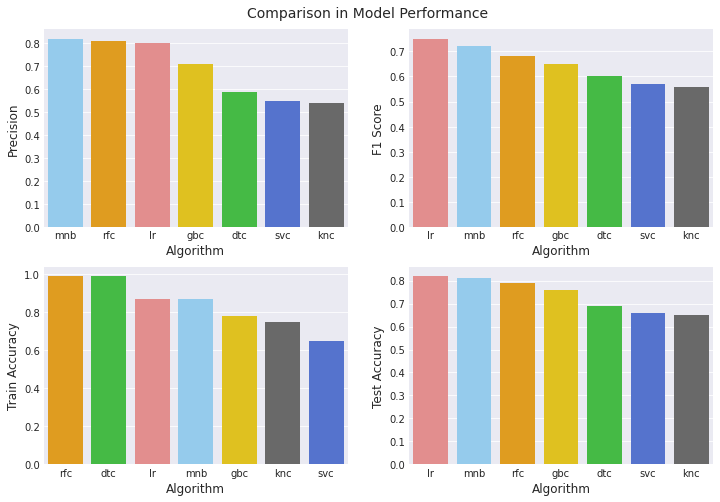

In [67]:
# create a list of metrics
metrics = ['Precision', 'F1 Score', 'Train Accuracy', 'Test Accuracy']

# create the figure
fig = plt.figure(figsize=(12, 8))

# adjust the height of the padding between subplots to avoid overlapping
#plt.subplots_adjust(hspace=0.3)

# set the color palette
colors = {'lr':'lightcoral',
          'mnb':'lightskyblue',
          'rfc':'orange',
          'gbc':'gold',
          'dtc':'limegreen',
          'svc':'royalblue',
          'knc':'dimgray'}

# add a centered suptitle to the figure
plt.suptitle('Comparison in Model Performance', fontsize=14, y=0.92)

# generate the histograms in a for loop
for i, metric in enumerate(metrics):
    
    # add a new subplot iteratively
    ax = plt.subplot(2, 2, i+1)
    ax = sns.barplot(x='Algorithm', y=metric, data=scores_df.sort_values(metric, ascending=False), palette=colors)
    
    # set x_label, y_label
    ax.set_xlabel('Algorithm', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    
# show the plots
plt.show()

***

## <a id="evaluate">🔎 Model Evaluation</a>
Let's perform cross validation and grid search using **RandomizedSearchCV on our top 3 models**.<br>  
*On a side note, I had ran the equivalent code with GridSearchCV on my local notebook and got similar results but a lot longer processing time.*

In [68]:
# import the libraries
from sklearn.model_selection import RandomizedSearchCV
from time import time

### Logistic Regression (lr)

In [69]:
# instantiate the model
lr = LogisticRegression(max_iter=10000, random_state=random_state)

# set the parameters
param_lr = {'C': [0.01, 0.1, 1, 10, 100]}

In [70]:
# construct RandomizedSearchCV object
rs_lr = RandomizedSearchCV(lr, param_lr, scoring='accuracy', cv=5, n_iter=5, n_jobs=-1, random_state=random_state)

# check the time
start = time()

# fit the model
rs_lr_fit = rs_lr.fit(X_train, y_train)

# check the time
end = time()

# store the results in a dataframe
rs_rl_df = pd.DataFrame(rs_lr_fit.cv_results_).sort_values('mean_test_score', ascending=False)

# show the top 5 models
rs_rl_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,68.562823,16.618805,0.255446,0.023976,1,{'C': 1},0.780788,0.797209,0.757800,0.798030,0.788177,0.784401,0.014729,1
3,242.786883,41.013718,0.268193,0.006549,10,{'C': 10},0.793103,0.800493,0.769294,0.770936,0.786535,0.784072,0.012233,2
4,568.440196,87.358406,0.198834,0.063867,100,{'C': 100},0.764368,0.779146,0.752053,0.754516,0.768473,0.763711,0.009817,3
1,17.522194,1.336529,0.281437,0.015114,0.1,{'C': 0.1},0.709360,0.710181,0.683908,0.717570,0.716749,0.707553,0.012281,4
0,14.521900,1.711085,0.264895,0.010424,0.01,{'C': 0.01},0.648604,0.650246,0.628079,0.657635,0.662562,0.649425,0.011807,5


In [71]:
# print out the algorithm, fitting time, best parameters, and best score
print('Logistic Regression:\nProcessing Time: {} secs | Best Parameters: {} | Best Score: {}'.format(round(end-start, 2),
                                                                                                     rs_lr_fit.best_params_, 
                                                                                                     round(rs_lr_fit.best_score_, 2)))

Logistic Regression:
Processing Time: 1374.41 secs | Best Parameters: {'C': 1} | Best Score: 0.78


### Multinomial Naive Bayes (mnb)

In [72]:
# instantiate the model
mnb = MultinomialNB()

# set the parameters
param_mnb = {'alpha': [0.0001, 0.001, 0.1, 1, 10, 100,1000]}

In [73]:
# construct RandomizedSearchCV object
rs_mnb = RandomizedSearchCV(mnb, param_mnb, scoring='accuracy', cv=5, n_iter=7, n_jobs=-1, random_state=random_state)

# check the time
start = time()

# fit the model
rs_mnb_fit = rs_mnb.fit(X_train, y_train)

# check the time
end = time()

# store the results in a dataframe
rs_mnb_df = pd.DataFrame(rs_mnb_fit.cv_results_).sort_values('mean_test_score', ascending=False)

# show the top 5 models
rs_mnb_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.176129,0.151600,0.318310,0.054259,1,{'alpha': 1},0.773399,0.786535,0.757800,0.807061,0.800493,0.785057,0.017908,1
2,1.053619,0.040866,0.303578,0.029594,0.1,{'alpha': 0.1},0.770115,0.777504,0.761084,0.784072,0.777504,0.774056,0.007847,2
1,1.077130,0.023788,0.290411,0.033899,0.001,{'alpha': 0.001},0.757800,0.765189,0.747947,0.766831,0.766831,0.760920,0.007296,3
0,1.108793,0.049489,0.306010,0.028155,0.0001,{'alpha': 0.0001},0.756158,0.764368,0.743842,0.764368,0.765189,0.758785,0.008167,4
4,1.192414,0.121995,0.321837,0.082346,10,{'alpha': 10},0.558292,0.558292,0.558292,0.558292,0.558292,0.558292,0.000000,5


In [74]:
# print out the algorithm, fitting time, best parameters, and best score
print('Multinomial Naive Bayes:\nProcessing Time: {} secs | Best Parameters: {} | Best Score: {}'.format(round(end-start, 2),
                                                                                                         rs_mnb_fit.best_params_,
                                                                                                         round(rs_mnb_fit.best_score_, 2)))

Multinomial Naive Bayes:
Processing Time: 14.59 secs | Best Parameters: {'alpha': 1} | Best Score: 0.79


### Random Forest Classifier (rfc)

In [75]:
# instantiate the model
rfc = RandomForestClassifier(random_state=random_state)

# set the parameters
param_rfc = {'n_estimators': [100, 200, 300, 500],
             'max_depth': [4, 6, 8, None]}

In [76]:
# construct RandomizedSearchCV object
rs_rfc = RandomizedSearchCV(rfc, param_rfc, cv=5, n_iter=16, n_jobs=-1, random_state=random_state)

# check the time
start = time()

# fit the model
rs_rfc_fit = rs_rfc.fit(X_train, y_train)

# check the time
end = time()

# store the results in a dataframe
rs_rfc_df = pd.DataFrame(rs_rfc_fit.cv_results_).sort_values('mean_test_score', ascending=False)

# show the top 5 models in a dataframe
rs_rfc_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,56.977363,0.292162,0.641695,0.027167,200,None,"{'n_estimators': 200, 'max_depth': None}",0.775041,0.789819,0.768473,0.796388,0.779146,0.781773,0.010074,1
14,84.300014,0.747307,0.811308,0.020861,300,None,"{'n_estimators': 300, 'max_depth': None}",0.777504,0.786535,0.766010,0.798030,0.779967,0.781609,0.010553,2
15,130.266712,13.477205,1.029428,0.216400,500,None,"{'n_estimators': 500, 'max_depth': None}",0.773399,0.787356,0.766831,0.799672,0.780788,0.781609,0.011365,2
12,28.885816,0.323498,0.431422,0.023368,100,None,"{'n_estimators': 100, 'max_depth': None}",0.777504,0.783251,0.759442,0.789819,0.780788,0.778161,0.010194,4
11,9.716844,0.072453,0.368651,0.023070,500,8,"{'n_estimators': 500, 'max_depth': 8}",0.633826,0.636289,0.634647,0.646962,0.637110,0.637767,0.004742,5


In [77]:
# print out the algorithm, fitting time, best parameters, and best score
print('Random Forest Classifier:\nProcessing Time: {} secs | Best Parameters: {} | Best Score: {}'.format(round(end-start, 2),
                                                                                                          rs_rfc_fit.best_params_, 
                                                                                                          round(rs_rfc_fit.best_score_, 2)))

Random Forest Classifier:
Processing Time: 556.94 secs | Best Parameters: {'n_estimators': 200, 'max_depth': None} | Best Score: 0.78


### Testing the Final Models

RandomizedSearchCV found that Logistic Regression and Multinomial Naive Bayes perform the best with the default hyperparameter settings. Let's test our models with **the default settings for lr and mnb, but the updated setting for rfc**.

In [78]:
# create a dictionary of the final models
final_models = {'lr': LogisticRegression(max_iter=10000, random_state=random_state),
                'mnb': MultinomialNB(),
                'rfc': RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1)} 

In [79]:
# run the models with classify() function we created above
for name, clf in final_models.items():
    i_precision, i_fscore, i_train_accuracy, i_test_accuracy = classify(clf, X_train, X_val, y_train, y_val)
    
    # check the time
    start = time()
    
    # fit and predict
    y_pred = clf.fit(X_train, y_train).predict(X_val)
    
    # check the time
    end = time()
    
    # print out the scores and classification reports
    print('[{}]\nProcessing Time: {} secs | Test Accuracy: {} | Precision: {} | F1-score: {}\n'.format(name, 
                                                                                                  round(end-start, 2),
                                                                                                  round(i_test_accuracy, 2),
                                                                                                  round(i_precision, 2), 
                                                                                                  round(i_fscore, 2)))

[lr]
Processing Time: 66.14 secs | Test Accuracy: 0.82 | Precision: 0.8 | F1-score: 0.75

[mnb]
Processing Time: 0.73 secs | Test Accuracy: 0.81 | Precision: 0.82 | F1-score: 0.72

[rfc]
Processing Time: 20.06 secs | Test Accuracy: 0.79 | Precision: 0.82 | F1-score: 0.68



***

## <a id="select">⚖️ Final Model Selection</a>

Of our top three models:

- The Logistic Regression model and Multinomial Naive Bayes model are close in terms of accuracy, with lr slightly higher, but mnb is faster and gives slightly higher precision.
- In terms of F-1 score, the Logistic Regression model is the highest. 
- The Random Forest Classifier model does not perform as well as the other two above.

Even though it takes longer, **let's deploy the lr model** with the actual test data!

In [80]:
# fit the cleaned text to the vectorizer
tfidf_vect_fit = tfidf.fit(train_df['text_cleaned'])

# create the vectorized columns
tfidf_train = tfidf_vect_fit.transform(train_df['text_cleaned'])
tfidf_test = tfidf_vect_fit.transform(test_df['text_cleaned'])

In [81]:
# create dataframes from the sparse matrices
tfidf_train_df = pd.DataFrame(tfidf_train.toarray())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray())

# get the feature names from our stored vectorizers and assign them to tfidf_train_df and tfidf_test_df
# to avoid getting 'FutureWarning: Feature names only support names that are strings.'
tfidf_train_df.columns = tfidf.get_feature_names_out()
tfidf_test_df.columns = tfidf.get_feature_names_out()

In [82]:
# concatenate back the vectorized data and the 4 features we've created
X_train_vect = pd.concat([train_df[['word_count', 'char_count', 'avg_word_len', 'propn_count', 'punc_per']].reset_index(drop=True),
                          tfidf_train_df], axis=1)
X_test_vect = pd.concat([test_df[['word_count', 'char_count', 'avg_word_len', 'propn_count', 'punc_per']].reset_index(drop=True),
                         tfidf_test_df], axis=1)

# store the labels
y_train = train_df['target']

# check the shape
print(X_train_vect.shape, X_test_vect.shape)

(7613, 11719) (3263, 11719)


In [83]:
# fit the model and check the processing time
start = time()
final_model = final_models['lr']
final_model_fit = final_model.fit(X_train_vect, y_train)
end = time()
fit_time = end - start

# make predictions and check the processing time
start = time()
final_pred = final_model.predict(X_test_vect)
end = time()
pred_time = end - start

print('Fit time: {} secs | Predict time: {} secs'.format(round(fit_time, 2), round(pred_time, 2)))

Fit time: 106.13 secs | Predict time: 0.5 secs


### Submission

In [84]:
# create a dataframe for submission
submission = test_df[['id']].reset_index(drop=True)
submission['target'] = final_pred.astype('int64')

In [85]:
# check the dataframe
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [86]:
# export the dataframe as a csv file 
submission.to_csv('submission.csv', index=False)

### Further Exploration
In this notebook, we've explored a limited number of algorithms, models, and hyperparameter settings. In practice, it is not uncommon to test over hundreds or even higher number of models. Some other ways that would help us find the best model to solve the given NLP problem include:

- Using different vectorizers (e.g., Word2Vec, N-grams)
- Including parts of the text we removed (e.g., stopwords)
- Exploring different hyperparameter settings within each algorithm (e.g., adding 'max_features' parameter and a few possible values of it to the RandomizedSearchCV object)
- Using different hyperparameter optimization methods (e.g., Bayesian method using Optuna) 

📌 In the future, I'm planning to compare the traditional machine learning models we've covered in this notebook and LSTM. Stay tuned! **Thank you for reading my notebook and please upvote if you find it helpful!**